In [1]:
import sys
import datetime

import numpy as np
from scipy import integrate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from struct import pack, unpack

sys.path.insert(0, "../")
from paths import FIG_DIR, DATA_DIR

In [2]:
def compute_lcs_volume_vectorized(p_matr, ssb):
    normal = - p_matr @ ssb
    normal_short = np.where(normal < 0, normal, 0)
    with np.errstate(divide='ignore'):
        factors = normal_short[:, :, None] / (normal_short[:, :, None] - normal[:, None, :])
        factors = np.nan_to_num(factors, copy=False, nan=1.0, posinf=1.0, neginf=1.0)
    summands = np.prod(factors, axis=2)
    return np.sum(summands, axis=1)

In [ ]:
# intr_dict = {4: 0.0013068658490566038, 5: 0.0023164428679245284} # compare Notebook 5_2 and 5_3
# with open(DATA_DIR / '5_4_sim_transitive.dat', 'wb') as file:
#     file.write(pack('d' * len(intr_dict) , *intr_dict.values()))

In [3]:
with open(DATA_DIR / '5_4_sim_transitive.dat', 'rb') as file:
    packed = file.read()
    read = list(unpack('d' * (len(packed) // 8), packed)) # 8 bytes per double
intr_dict_read = {i + 4: read[i] for i in range(len(read))}
intr_dict_read

{4: 0.0013068658490566038, 5: 0.0023164428679245284}

In [ ]:
num_samples = 2.65 * 10**10 #1 sample corresponds to 3 lotteries, a triple!

with open(DATA_DIR / '5_4_sim_transitive.dat', 'rb') as file:
    packed = file.read()
    read = list(unpack('d' * (len(packed) // 8), packed)) # 8 bytes per double
intr_dict = {i + 4: read[i] for i in range(len(read))}

for m in range(4 + len(intr_dict), 16):
    now = datetime.datetime.now()
    print(f"Starting {m} at {now.strftime('%Y-%m-%d %H:%M:%S')}")

    rng = np.random.default_rng(2025 + m)
    ssb_tr = np.triu(np.ones((m, m))) - np.tril(np.ones((m, m)))
    alpha = np.ones(m)
    batch_size = 10**7

    batch_results = []

    for i in range(len(batch_results)*batch_size, int(num_samples), batch_size):
        lotteries = rng.dirichlet(alpha, (3, batch_size))
        comp01 = (np.sum(lotteries[0,:,:] @ ssb_tr * lotteries[1,:,:], axis=1) > 0).astype(int)
        comp12 = (np.sum(lotteries[1,:,:] @ ssb_tr * lotteries[2,:,:], axis=1) > 0).astype(int)
        comp20 = (np.sum(lotteries[2,:,:] @ ssb_tr * lotteries[0,:,:], axis=1) > 0).astype(int)
        num_intr = np.sum(comp01 + comp12 + comp20 == 0) + np.sum(comp01 + comp12 + comp20 == 3)
        batch_results.append(num_intr/batch_size)

    now = datetime.datetime.now()
    print(f"Finished {m} at {now.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Results for m={m}: np.mean(batch_results)={np.mean(batch_results)}, np.std(batch_results)={np.std(batch_results)}, len(batch_results)={len(batch_results)}")
    intr_dict[m] = np.mean(batch_results)
    with open(DATA_DIR / '5_4_sim_transitive.dat', 'wb') as file:
        file.write(pack('d' * len(intr_dict) , *intr_dict.values()))

Starting 13 at 2025-04-28 08:53:12
Finished 13 at 2025-04-28 13:08:44
Results for m=13: np.mean(batch_results)=0.0033663879622641505, np.std(batch_results)=1.803149054624522e-05, len(batch_results)=2650
Starting 14 at 2025-04-28 13:08:44
Finished 14 at 2025-04-28 17:40:36
Results for m=14: np.mean(batch_results)=0.003281799886792453, np.std(batch_results)=1.8109184680667012e-05, len(batch_results)=2650


In [4]:
intr_dict

{4: 0.0013068658490566038,
 5: 0.0023164428679245284,
 6: 0.0029405492452830194,
 7: 0.0032902126037735848,
 8: 0.003469022490566038,
 9: 0.003539500716981132,
 10: 0.0035421367924528303,
 11: 0.0035046867169811315,
 12: 0.003442786603773585,
 13: 0.0033663879622641505,
 14: 0.003281799886792453}

In [ ]:
# sample_dict = {"4": 0.001306, "5": 0.002625, "6": 0.003944, "7": 0.001733}

In [5]:
df = pd.DataFrame(intr_dict.items(), columns=["num_alt", "prob_intr"])
df

,num_alt,prob_intr
0,4,0.001307
1,5,0.002316
2,6,0.002941
3,7,0.003290
4,8,0.003469
5,9,0.003540
6,10,0.003542
7,11,0.003505
8,12,0.003443
9,13,0.003366


<Axes: xlabel='num_alt', ylabel='prob_intr'>

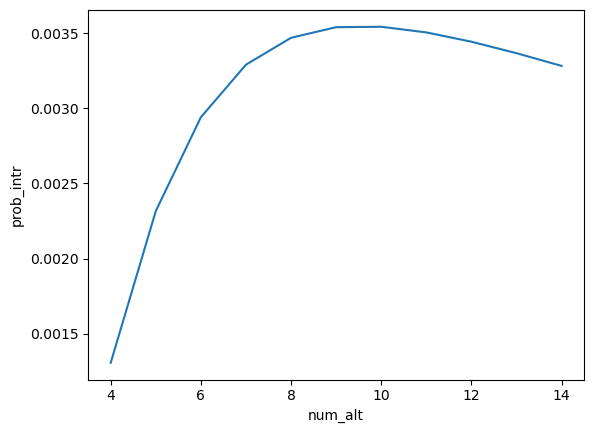

In [6]:
sns.lineplot(x='num_alt', y='prob_intr', data=df, err_style='bars')

<ErrorbarContainer object of 3 artists>

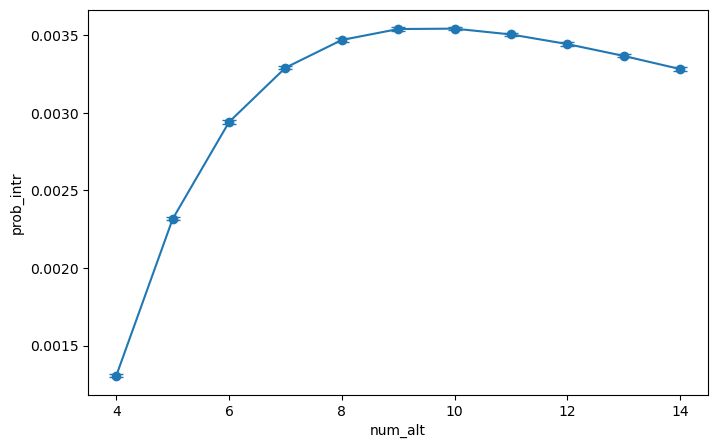

In [9]:
df['error'] = 1e-5

# Plot with error bars
plt.figure(figsize=(8, 5))
line = sns.lineplot(x='num_alt', y='prob_intr', data=df, err_style='bars', errorbar=None)
plt.errorbar(df['num_alt'], df['prob_intr'], yerr=df['error'], fmt='o', color=line.lines[0].get_color(), capsize=5)